<a href="https://colab.research.google.com/github/EnriqueGRivas/Analisis_Bluex/blob/main/PP1/7_Retail_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font color=black size = 6 face="Verdana"><center><strong>SUPPLY CHAIN ANALYTICS - Gestión Moderna de la Cadena de Suministros</center></font>


  <font color=black><center>Fecha: 03-09-2024</center>


  <font color=#48c9b0><center>Elaborado por: Mg. Ec. Enrique F. Gutierrez Rivasplata</center>

<center>
<h1 style="background-color:seagreen; color:white" ><Strong>RETAIL ANALYTICS </h1>



### **Importando Paquetes:**

In [ ]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np
import missingno as msno
import datetime as dt
import math

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración matplotlib
# ==============================================================================
plt.rcParams['image.cmap'] = "bwr"
#plt.rcParams['figure.dpi'] = "100"
plt.rcParams['savefig.bbox'] = "tight"
%matplotlib inline

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

# Para el Forecast
# ==============================================================================
import sklearn
from sklearn.model_selection import train_test_split
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

# Importando el fbprophet
# ==============================================================================
!pip install prophet
from prophet import Prophet # importar la clase Prophet desde el paquete Prophet

# Usar prophet en lugar de fbprophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import add_changepoints_to_plot
from prophet.plot import plot_cross_validation_metric

<a id='part1'></a>
## <font color=#ba4a00><strong>Lectura y Comprensión de los Datos:

In [ ]:
from google.colab import files

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Leer el archivo Excel con los datos simulados
# ==============================================================================
data = pd.read_excel('/content/drive/MyDrive/Análisis - Python/DATOS/Data1.xlsx')


# Copiamos el dataframe
# ==============================================================================
df = data.copy()

# Mostrar las primeras filas del dataframe
# ==============================================================================
df.head()

,F_Orden,#Orden,Factura,Cod_Prod,Proceso,Tipo_Envio,Cod_Cliente,F_Vencimiento,F_Envio,Cant_Solicitada,...,Ingresos_por_Distribucion_SDD,Ingresos_por_Falsos_Fletes,Ingreso_Picking,Ingreso_Posicion_Rack,Ingreso_Shipping,Slotting_Recepcion_Prom,Total_Ingresos_Almacen,Ingresos_Distribucion,Ingresos_Cancelaciones_Totales,Total_Ingresos_Gestion_Logistica
0,2015-01-03,2204383,3111,204978,Shipping,Standard Class,CON-10004331147,2015-01-03,2015-01-03,80,...,66603.25,0.0,349.650000,164.365385,223.8,291.375000,560.635385,66603.25,528.600,67692.485385
1,2015-01-03,2204384,3112,1097514,Shipping,Standard Class,EMP-20449216343,2015-01-05,2015-01-05,27,...,3379.95,0.0,413.696970,194.472935,49.0,344.747475,663.329501,3379.95,70.425,4113.704501
2,2015-01-03,2204387,3115,204754,Shipping,Standard Class,CON-10004331147,2015-01-05,2015-01-05,22,...,66150.00,0.0,8.910000,4.188462,11.8,7.425000,14.286462,66150.00,4488.750,70653.036462
3,2015-01-03,2204382,3110,1001830,Shipping,Standard Class,CON-10181604579,2015-01-05,2015-01-06,90,...,0.00,32387.4,137.576863,64.672884,19.2,114.647385,220.593328,21752.75,32387.400,54360.743328
4,2015-01-05,2204395,3123,1001830,Shipping,Standard Class,EMP-20447989051,2015-01-06,2015-01-06,81,...,30453.85,32387.4,137.576863,64.672884,19.2,114.647385,220.593328,30453.85,32387.400,63061.843328


In [ ]:
# Mostramos el número de filas y columnas
# ==============================================================================
print("La cantidad de columnas es: ",df.shape[1])
print("La cantidad de filas es: ",df.shape[0])

La cantidad de columnas es:  81
La cantidad de filas es:  26162


In [ ]:
# Identificamos la cantidad de NANs en cada función y seleccione solo aquellas que tienen NANs
# ==============================================================================
total_NA = df.isnull().sum()[df.isnull().sum() != 0]

# Calculamos el porcentaje de NANs en cada característica
# ==============================================================================
percent_NA = df.isnull().sum()[df.isnull().sum() != 0]/df.shape[0]

# Resumen de nuestros hallazgos en un Data Frame
# ==============================================================================
missing = pd.concat([total_NA, percent_NA], axis=1, keys=['Total NANs', 'Porcentaje']).sort_values('Total NANs', ascending=False)
missing

,Total NANs,Porcentaje
Proceso_Devol,21535,0.82314
Cod_Cliente_Devol,21535,0.82314


<Axes: >

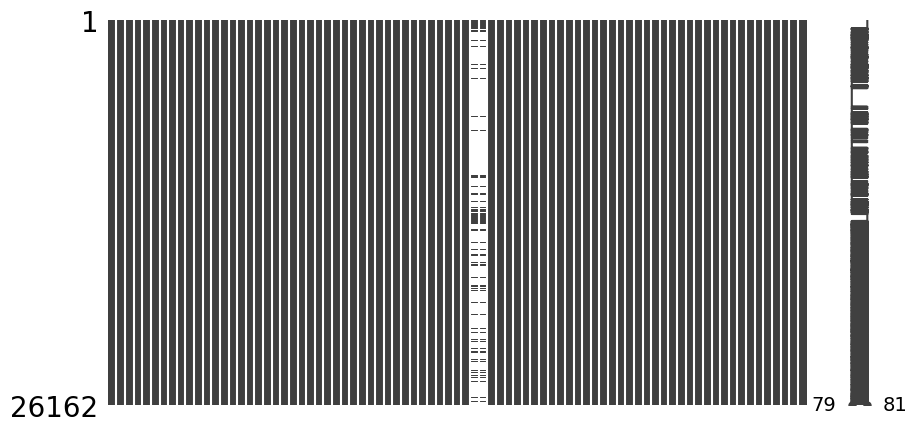

In [ ]:
# #Visualizar valores faltantes (NaN) con Missingno Library en funciones
# ==============================================================================
msno.matrix(df, figsize=(10, 5))

In [ ]:
# Comprobar si hay duplicados
# ==============================================================================

df.duplicated().sum()

2

In [ ]:
# Verificamos en qué fila se duplican
# ==============================================================================
df[df.duplicated(keep=False)]

,F_Orden,#Orden,Factura,Cod_Prod,Proceso,Tipo_Envio,Cod_Cliente,F_Vencimiento,F_Envio,Cant_Solicitada,...,Ingresos_por_Distribucion_SDD,Ingresos_por_Falsos_Fletes,Ingreso_Picking,Ingreso_Posicion_Rack,Ingreso_Shipping,Slotting_Recepcion_Prom,Total_Ingresos_Almacen,Ingresos_Distribucion,Ingresos_Cancelaciones_Totales,Total_Ingresos_Gestion_Logistica
19423,2016-12-09,2309999,13697,1095982,Shipping,Standard Class,CON-41544021,2016-12-10,2016-12-10,3,...,141697.5,0.0,127.920000,60.133333,12.8,106.60000,205.109333,141697.5,0.0,141902.609333
19424,2016-12-09,2309999,13697,1095982,Shipping,Standard Class,CON-41544021,2016-12-10,2016-12-10,3,...,141697.5,0.0,127.920000,60.133333,12.8,106.60000,205.109333,141697.5,0.0,141902.609333
20494,2017-03-04,2338622,14128,1100101,Shipping,Standard Class,CON-67414403,2017-03-06,2017-03-06,6,...,16695.0,0.0,8.366605,3.933019,6.6,6.97217,13.415171,16695.0,0.0,16708.415171
20496,2017-03-04,2338622,14128,1100101,Shipping,Standard Class,CON-67414403,2017-03-06,2017-03-06,6,...,16695.0,0.0,8.366605,3.933019,6.6,6.97217,13.415171,16695.0,0.0,16708.415171


In [ ]:
# Procediendo a eliminar las mismas
# ==============================================================================
#df = df.drop_duplicates() # Primer método
df.drop_duplicates(inplace=True)

<a id='part2'></a>
## <font color=#ba4a00><strong>Exploratory Data Analysis (EDA):

In [ ]:
# Valores únicos de fecha
# ==============================================================================
df['F_Orden'].nunique()

926

In [ ]:
# Ventas de fin de semana
# ==============================================================================
ventas_fin_semana = df[df['Dia_Semana'].isin(['Sábado', 'Domingo'])]
ventas_fin_semana.head(2)

,F_Orden,#Orden,Factura,Cod_Prod,Proceso,Tipo_Envio,Cod_Cliente,F_Vencimiento,F_Envio,Cant_Solicitada,...,Ingresos_por_Distribucion_SDD,Ingresos_por_Falsos_Fletes,Ingreso_Picking,Ingreso_Posicion_Rack,Ingreso_Shipping,Slotting_Recepcion_Prom,Total_Ingresos_Almacen,Ingresos_Distribucion,Ingresos_Cancelaciones_Totales,Total_Ingresos_Gestion_Logistica
0,2015-01-03,2204383,3111,204978,Shipping,Standard Class,CON-10004331147,2015-01-03,2015-01-03,80,...,66603.25,0.0,349.65000,164.365385,223.8,291.375000,560.635385,66603.25,528.600,67692.485385
1,2015-01-03,2204384,3112,1097514,Shipping,Standard Class,EMP-20449216343,2015-01-05,2015-01-05,27,...,3379.95,0.0,413.69697,194.472935,49.0,344.747475,663.329501,3379.95,70.425,4113.704501


In [ ]:
# Ventas acumuladas de Sabado y Domingo
# ==============================================================================
ventas_sab_dom = ventas_fin_semana.groupby('F_Orden')['Venta_Totales'].sum().reset_index()
ventas_sab_dom

,F_Orden,Venta_Totales
0,2015-01-03,29345.21
1,2015-01-10,4374.11
2,2015-01-17,9462.04
3,2015-01-24,197993.14
4,2015-02-07,9567.80
...,...,...
228,2017-12-17,867096.90
229,2017-12-23,584297.31
230,2017-12-24,543390.41
231,2017-12-30,2157956.64


In [ ]:
# Suma total de Ventas en los Sabados y Domingos
# ==============================================================================
ventas_sab_dom['Venta_Totales'].sum()

45183549.2

#### **Histogramas para variables a Trabajar:**

In [ ]:
# Variables Continuas
# ==============================================================================
Variables = df.loc[:,df.dtypes == "float64"].columns
Variables

Index(['Peso', 'Volumen', 'Descuento', 'P_Compra', 'P_Venta', 'Venta_Totales',
       'Costo_Totales', 'Ganancia', 'Volumen_Total', 'Peso_Total',
       'Inventario_Total', 'Descuento_Total', 'Ganancia_Total', 'Compra_Total',
       'Devolucion_Total', '%Devolucion', 'Vol_Compras', 'Ingresos_Cajas',
       'Ingresos_por_Cancelaciones', 'Ingresos_por_Distribucion_NBD',
       'Ingresos_por_Distribucion_SDD', 'Ingresos_por_Falsos_Fletes',
       'Ingreso_Picking', 'Ingreso_Posicion_Rack', 'Ingreso_Shipping',
       'Slotting_Recepcion_Prom', 'Total_Ingresos_Almacen',
       'Ingresos_Distribucion', 'Ingresos_Cancelaciones_Totales',
       'Total_Ingresos_Gestion_Logistica'],
      dtype='object')

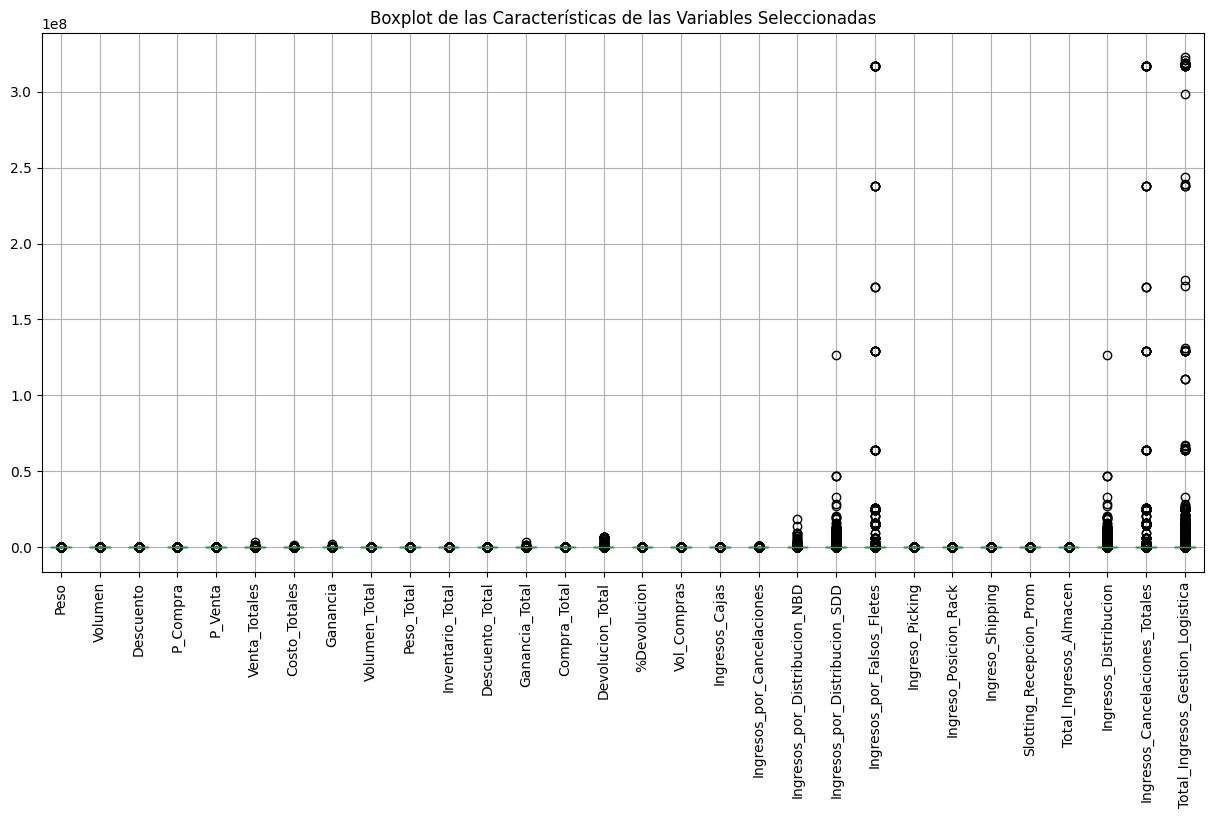

,count,mean,std,min,25%,50%,75%,max
Peso,26160.0,6.01,10.65,0.00,0.48,2.46,6.03,1.455000e+02
Volumen,26160.0,0.07,0.11,0.00,0.03,0.03,0.07,3.890000e+00
Descuento,26160.0,0.13,0.19,0.00,0.00,0.00,0.20,8.000000e-01
P_Compra,26160.0,283.14,528.60,0.02,12.69,93.65,350.11,1.717421e+04
P_Venta,26160.0,610.16,1023.86,0.03,34.95,207.35,849.50,2.763728e+04
Venta_Totales,26160.0,6594.73,36389.89,0.00,187.25,898.50,3747.50,3.625779e+06
Costo_Totales,26160.0,3194.08,16652.41,0.00,70.22,352.32,1569.24,1.382177e+06
Ganancia,26160.0,3400.65,20860.65,-2260.70,79.12,396.01,1756.00,2.243602e+06
Volumen_Total,26160.0,0.74,2.51,0.00,0.09,0.18,0.48,1.031400e+02
Peso_Total,26160.0,63.77,266.78,0.00,1.68,9.24,38.03,1.353150e+04


In [ ]:
# Explorando las características de las variables (Boxplot de las características)
# ===================================================================================
plt.figure(figsize=(15, 7))
# Convert the Index to a list of strings
variables = df.loc[:, df.dtypes == "float64"].columns.tolist()
df.boxplot(column=variables)
plt.title('Boxplot de las Características de las Variables Seleccionadas')
plt.xticks(rotation=90)
plt.show()

# Resumen estadístico de las características
# ===================================================
df[variables].describe().transpose().round(2)

In [ ]:
# Escogemos las columnas a trabajar, filtrando el numero que corresponden a las mismas - MUESTRA 1
# ==============================================================================
#df2 = df.iloc[:, [48,49,50,51,52,55,56,57,58,59,67,68,69,70,71,72,73,74,75]]

#df2.head(3)

Para un análisis más detallado, agreguemos las columnas del año, mes, fecha del año y número de semana.

In [ ]:
# Desagregando la columna "Fecha de Pedido"
# ==============================================================================
#df['Y'] = df['F_Orden'].dt.year
#df['M'] = df['F_Orden'].dt.month
df['D'] = df['F_Orden'].dt.dayofyear # Cantidad de días en un año calendario
#df['Dia_Semana'] = df['F_Orden'].dt.day_name()
df['W'] = df['F_Orden'].dt.isocalendar().week # Cantidad de semanas que tiene un año calendario

<a id='part3'></a>
## <font color=#ba4a00><strong>Análisis de datos Categóricos:

Análisis de ventas por fechas, diferentes tipos de tiendas y condiciones.


**Trazar sumas de ventas semanales**

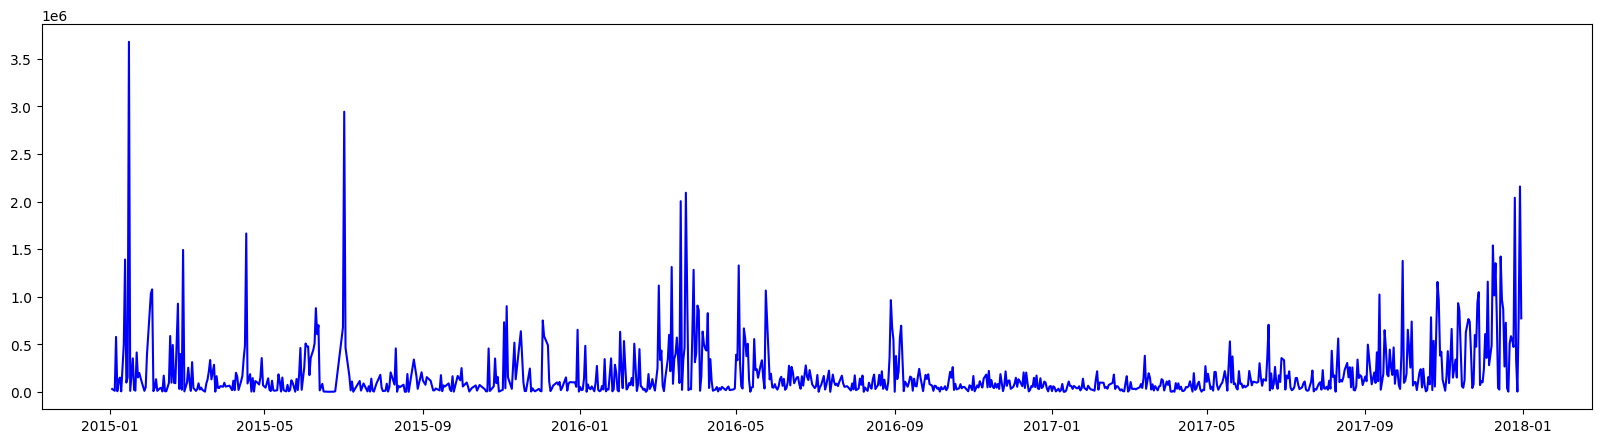

In [ ]:
# Trazamos las Ventas de Manera Semanal
# ==============================================================================
df_promedio_ventas_sem = df.groupby('F_Orden', as_index=False)\
    .agg({'Venta_Totales': 'sum'})

df_promedio_ventas_orden = df_promedio_ventas_sem.sort_values('Venta_Totales', ascending = False)

plt.figure(figsize=(20,5))

plt.plot(df_promedio_ventas_sem.F_Orden, df_promedio_ventas_sem.Venta_Totales, color = 'b')

plt.show()

**Trazar las ventas semanales medias por meses**

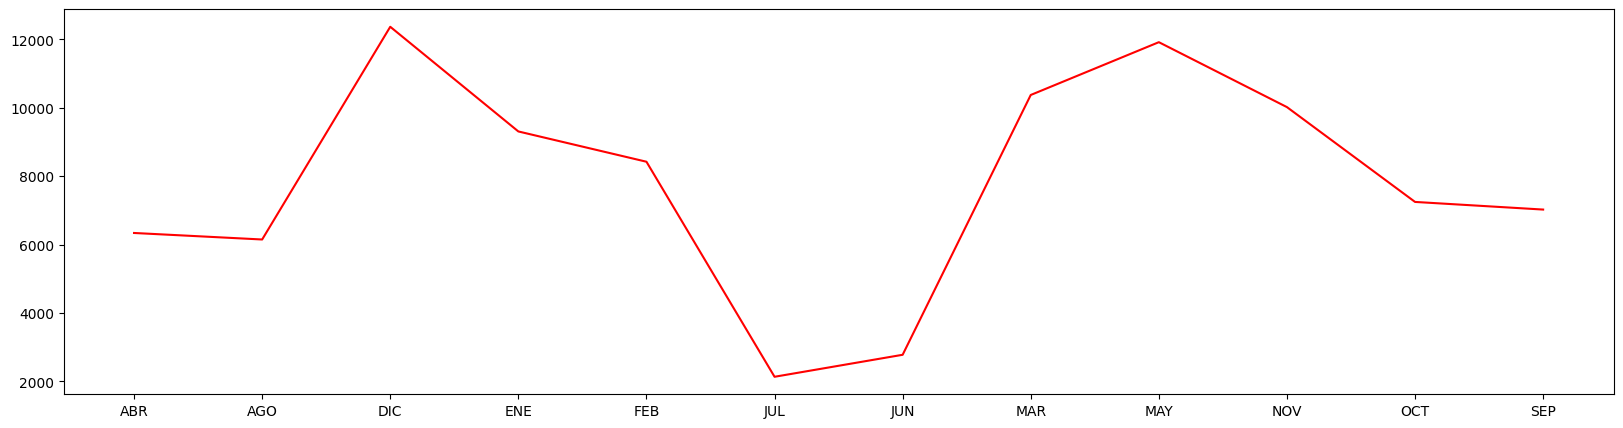

In [ ]:
# Trazo de Ventas de Manera Mensual
# ==============================================================================
df_prom_ventas_mes = df.groupby('Nombre_Mes', as_index=False)\
    .agg({'Venta_Totales': 'mean'}) # En promedio

plt.figure(figsize=(20,5))
plt.plot(df_prom_ventas_mes.Nombre_Mes, df_prom_ventas_mes.Venta_Totales, color = 'r')
plt.show()

In [ ]:
# Semanas más rentables
# ==============================================================================
df_promedio_ventas_orden.head()

,F_Orden,Venta_Totales
11,2015-01-16,3678907.47
145,2015-07-02,2943719.64
924,2017-12-30,2157956.64
341,2016-03-23,2092063.50
920,2017-12-26,2039853.81


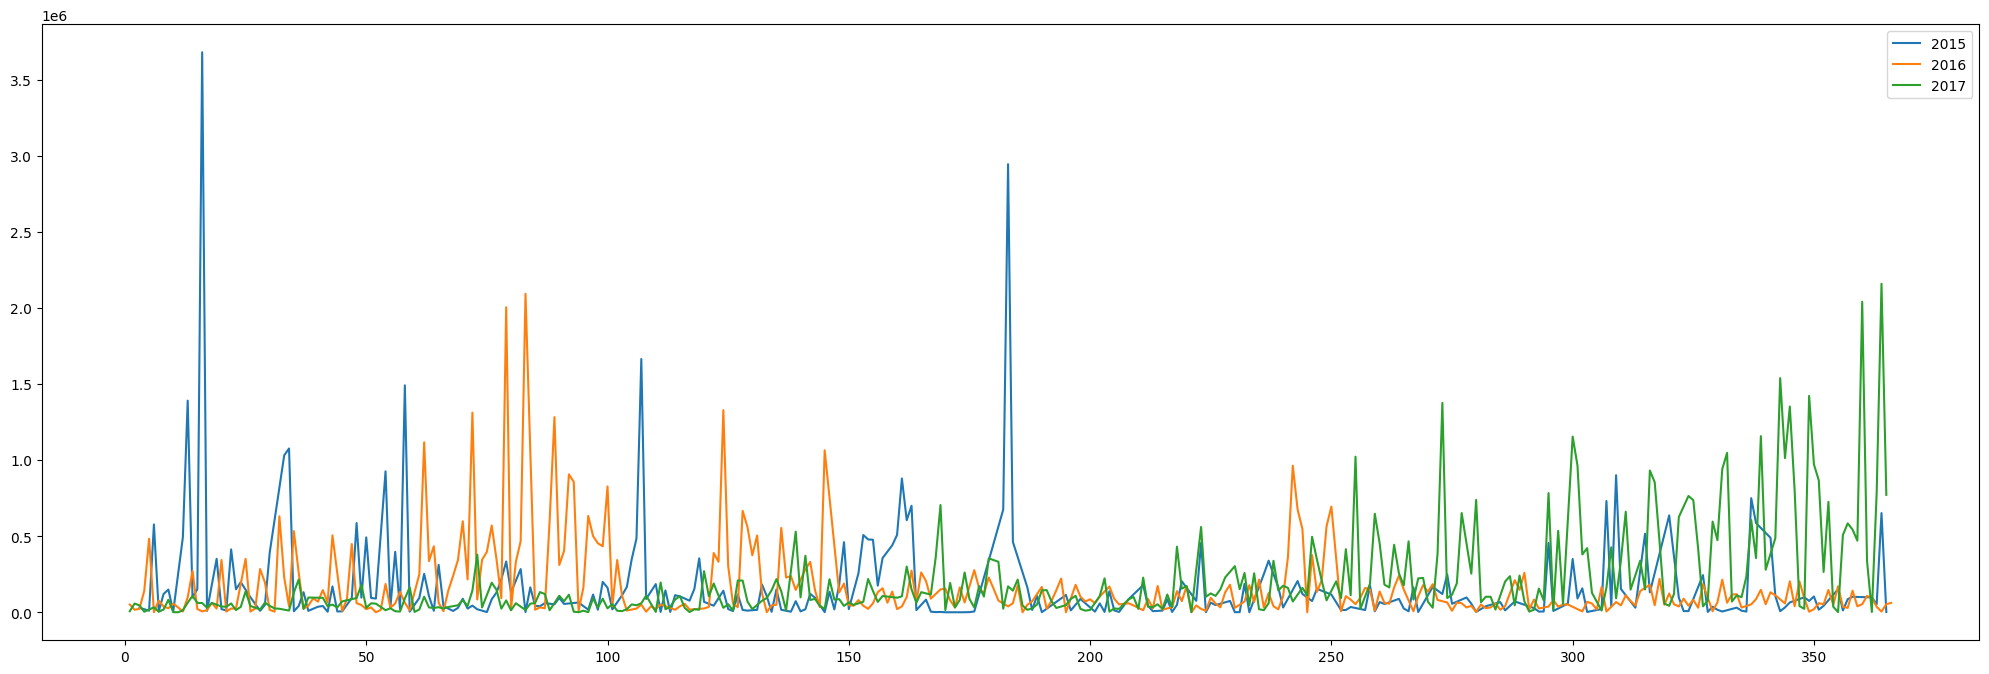

In [ ]:
# # Comparar ventas semanales por cada Año
# ==============================================================================
df15 = df.query('Year == 2015').groupby('D', as_index=False)\
    .agg({'Venta_Totales': 'sum'})
df16 = df.query('Year == 2016').groupby('D', as_index=False)\
    .agg({'Venta_Totales': 'sum'})
df17 = df.query('Year == 2017').groupby('D', as_index=False)\
    .agg({'Venta_Totales': 'sum'})

fig, ax = plt.subplots(figsize=(25,8))
ax.plot(df15.D, df15.Venta_Totales, label = "2015")
ax.plot(df16.D, df16.Venta_Totales, label = "2016")
ax.plot(df17.D, df17.Venta_Totales, label = "2017")
ax.legend()
plt.show()

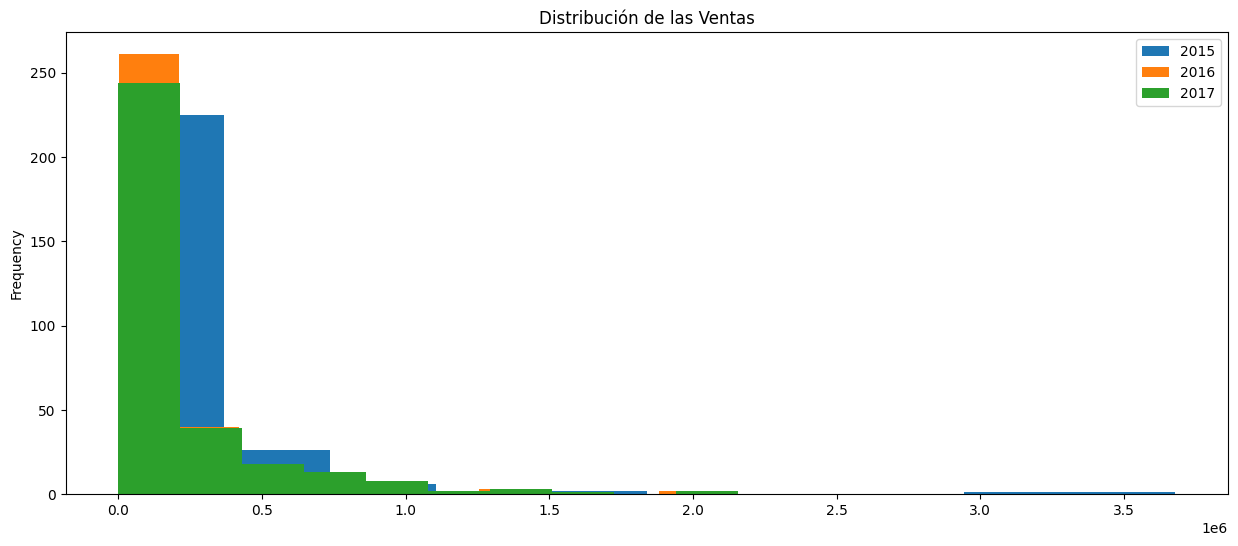

In [ ]:
# Distribución de sumas de Ventas
# ==============================================================================

fig, ax = plt.subplots(figsize=(15,6))

df15['Venta_Totales'].plot(kind='hist', title='Distribución de las Ventas', label = "2015");

df16['Venta_Totales'].plot(kind='hist', label = "2016");
df17['Venta_Totales'].plot(kind='hist', label = "2017");

ax.legend()
plt.show()

Las ventas de 2016 no tienen emisiones positivas significativas como en los años 2015 y 2017, quizás a la falta de datos o simplemente no hubo demanda de productos en este tiempo.

In [ ]:
# Últimas semanas de Ventas
# ==============================================================================
df_promedio_ventas_sem['F_Orden'].tail(5)

,F_Orden
921,2017-12-27
922,2017-12-28
923,2017-12-29
924,2017-12-30
925,2017-12-31


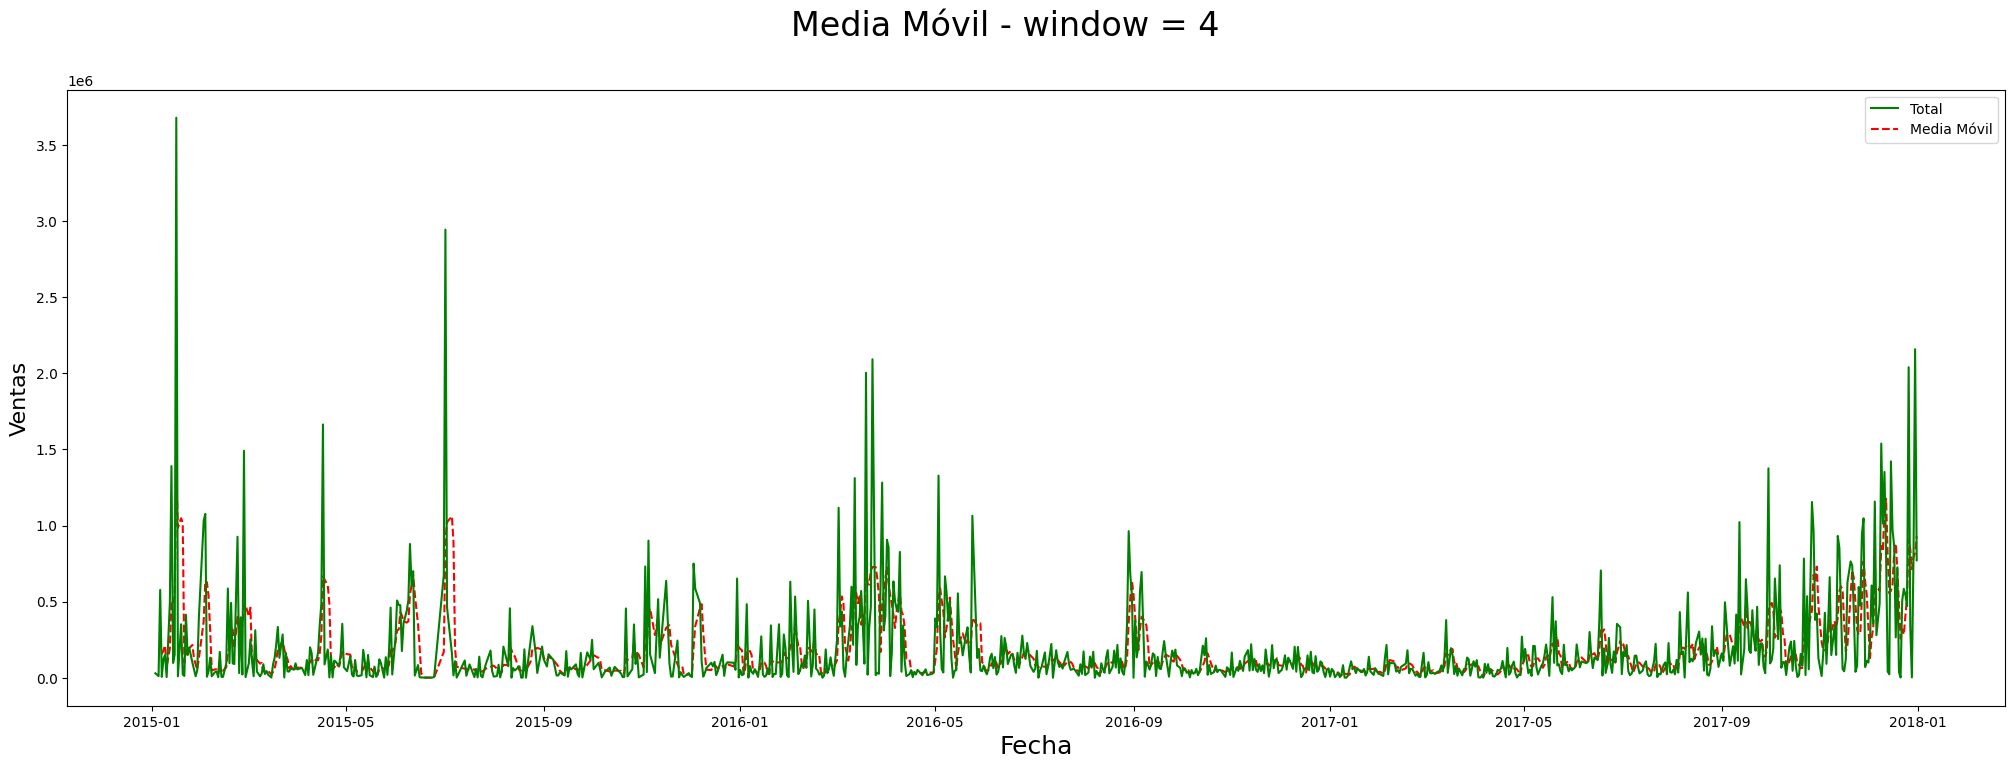

In [ ]:
# Media Movil (win = 4)
# ==============================================================================
df_promedio_ventas_sem['Media_mensual'] = df_promedio_ventas_sem['Venta_Totales'].rolling(4).mean() # Periodo de corte = 4 sem

fig = plt.figure(figsize=(25,8))
line1, = plt.plot(df_promedio_ventas_sem.F_Orden, df_promedio_ventas_sem.Media_mensual, '--', color='red')
line2, = plt.plot(df_promedio_ventas_sem.F_Orden, df_promedio_ventas_sem.Venta_Totales,  color='green')

fig.suptitle('Media Móvil - window = 4', fontsize=18)
plt.xlabel('Fecha', fontsize=13)
plt.ylabel('Ventas', fontsize=13)

plt.legend((line2, line1), ['Total', 'Media Móvil'])



plt.show()

Las semanas y meses más rentables coinciden con las fiestas de Dia del Padre, Fiestas Patrias, Navidad y Año Nuevo.

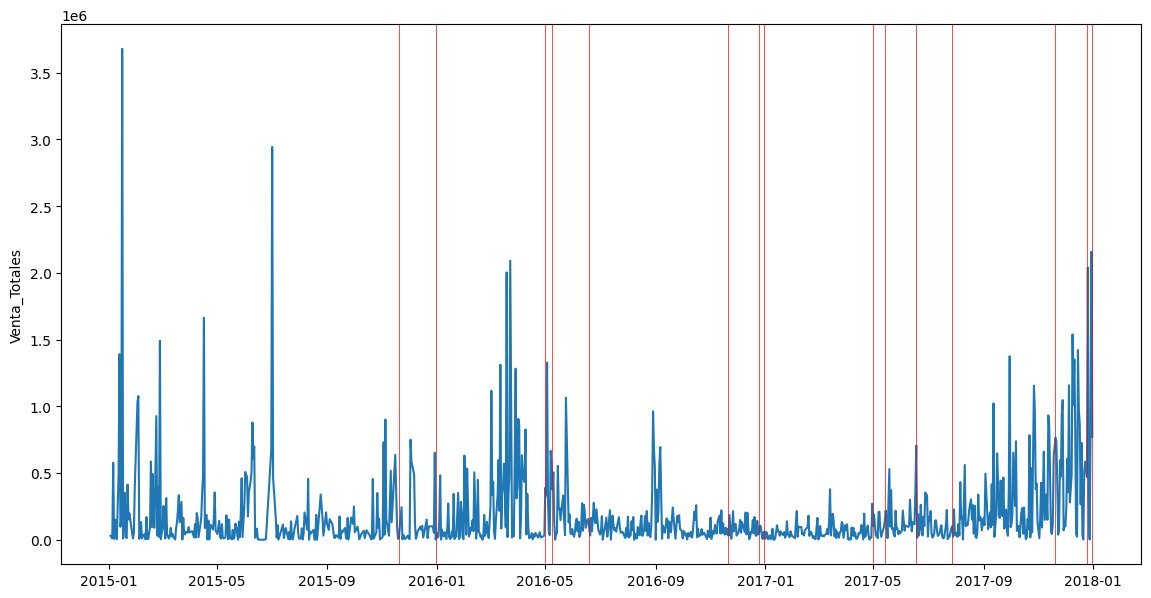

In [ ]:
# Las semanas de vacaciones están marcadas con líneas rojas
# ==============================================================================
df2 = df.groupby(by=['F_Orden'], as_index=False)['Venta_Totales'].sum()

f_1 = plt.figure(figsize=(12,6), dpi=100)
ax_1 = f_1.add_axes([0.0, 0.0, 0.9, 0.9])
ax_1.set_ylabel('Venta_Totales')
ax_1.plot(df2['F_Orden'], df2['Venta_Totales'])

# Dias Festivos en Perú a nivel Nacional desde 2015 al 2017
dias_festivos = {'1-5-2015', '1-5-2016', '1-5-2017','10-5-2015', '8-5-2016', '14-5-2017','21-6-2015', '19-6-2016', '18-6-2017','28-7-2015', '28-7-2016', '28-7-2017','20-11-2015', '20-11-2016', '20-11-2017','25-12-2015', '25-12-2016', '25-12-2017','31-12-2015', '31-12-2016', '31-12-2017'}

# Suponiendo que 'F_Orden' contiene fechas en el formato 'día-mes-año'
# Convierta dias_festivos en objetos de fecha y hora para comparar
from datetime import datetime
dias_festivos_dt = {datetime.strptime(d, '%d-%m-%Y') for d in dias_festivos}

for x in df2['F_Orden']: # Iterar sobre fechas en df2
    if x in dias_festivos_dt: # Comprueba si la fecha está en el set dias_festivos
        ax_1.axvline(x=x, color='red', linewidth=0.5)

**Diferencia de la suma de ventas semanales por día del año en comparación con un día anterior del año**

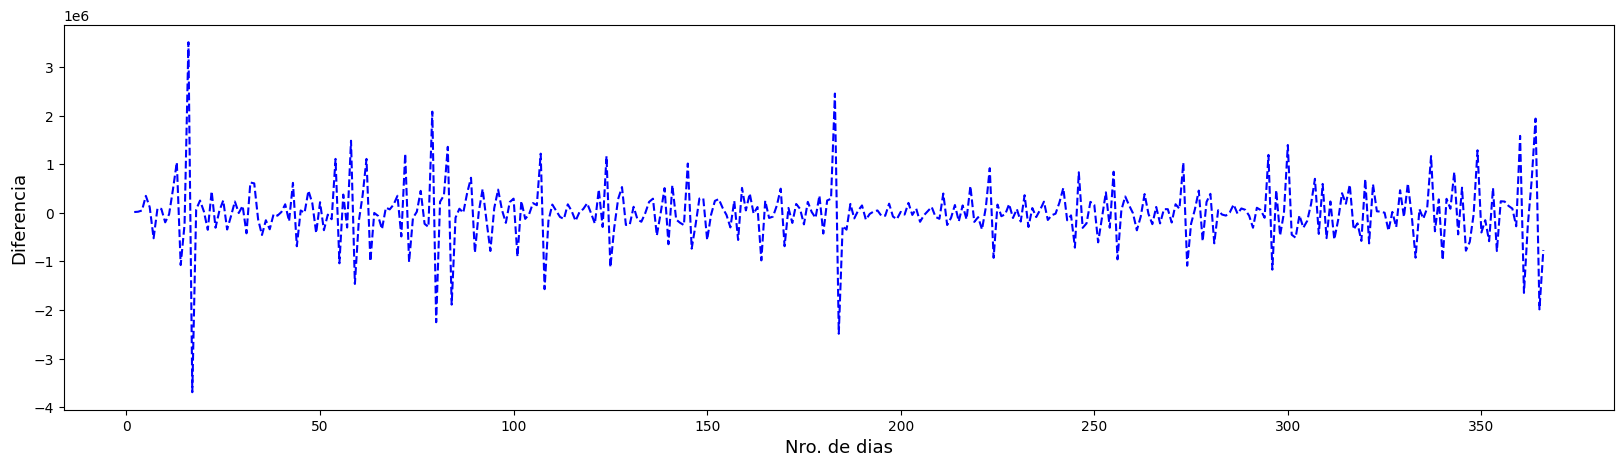

In [ ]:
# Comparación de Ventas Semanales vs dia anterior del Año
# ==============================================================================
df_SW = df.groupby('D', as_index=False)\
    .agg({'Venta_Totales': 'sum'})

df_SW['diferencia'] = df_SW['Venta_Totales'].diff()

plt.figure(figsize=(20,5))
plt.plot(df_SW.D, df_SW.diferencia, '--', color = 'b')
fig.suptitle('Comparación de Ventas Semanales Vs Ventas de dia Anterior del Año', fontsize=20)
plt.xlabel('Nro. de dias', fontsize=13)
plt.ylabel('Diferencia', fontsize=13)
plt.show()

**Diferencia de la suma de ventas semanales por fecha en comparación con una fecha anterior**

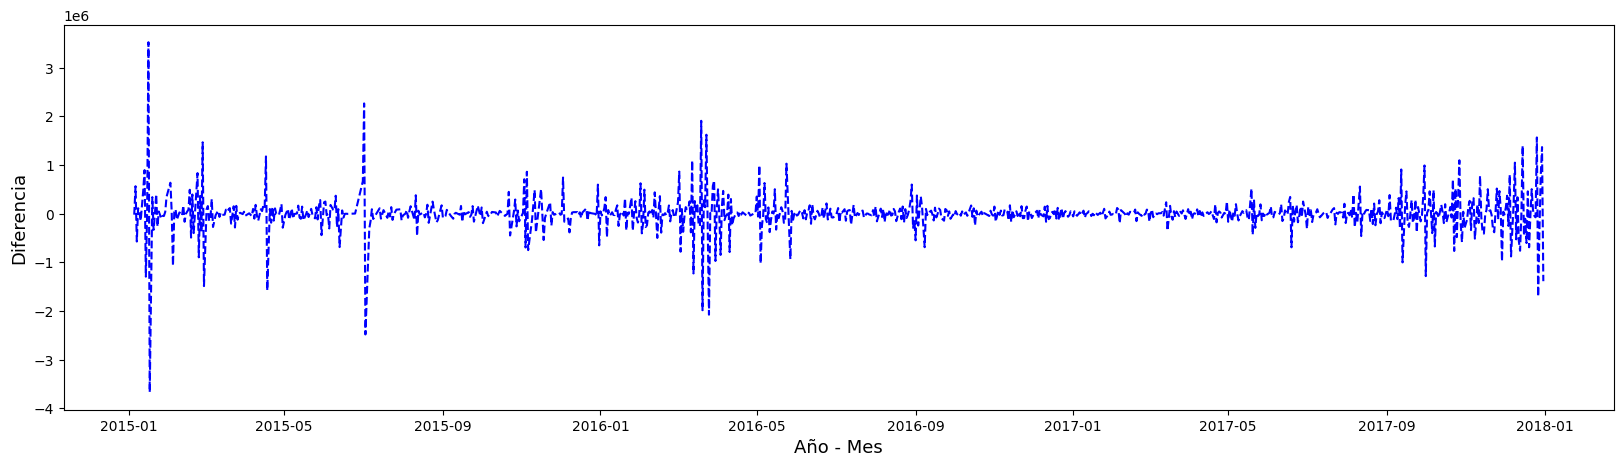

In [ ]:
# Diferencia de las Ventas Semanales Vs Fecha Anterior
# ==============================================================================
df_SW2 = df.groupby('F_Orden', as_index=False)\
    .agg({'Venta_Totales': 'sum'})

df_SW2['differ'] = df_SW2['Venta_Totales'].diff()

plt.figure(figsize=(20,5))
plt.plot(df_SW2.F_Orden, df_SW2.differ, '--', color = 'b')
fig.suptitle('Diferencia de las Ventas Semanales Vs Fecha Anterior', fontsize=20)
plt.xlabel('Año - Mes', fontsize=13)
plt.ylabel('Diferencia', fontsize=13)
plt.show()

<a id='part4'></a>
## <font color=#ba4a00><strong>Análisis de ventas por tipos de Productos:


In [ ]:
# Análisis por Tipo de Producto
# ==============================================================================
df_fami = df.groupby('Familia', as_index=False).agg(Mean=('Venta_Totales', 'mean'), Sum=('Venta_Totales', 'sum')).sort_values('Sum', ascending=False)
df_fami

,Familia,Mean,Sum
35,Guitarra,10609.525413,34555224.27
11,Bateria,24359.472872,20949146.67
5,Amplificador,11871.664513,17071453.57
51,Piano,29146.784410,10376255.25
27,Controlador,10548.199299,9925855.54
...,...,...,...
13,Boquilla,617.850000,6178.50
36,Herramientas,272.141429,5714.97
6,Armonica,520.074286,3640.52
34,Gabinete,186.206250,2979.30


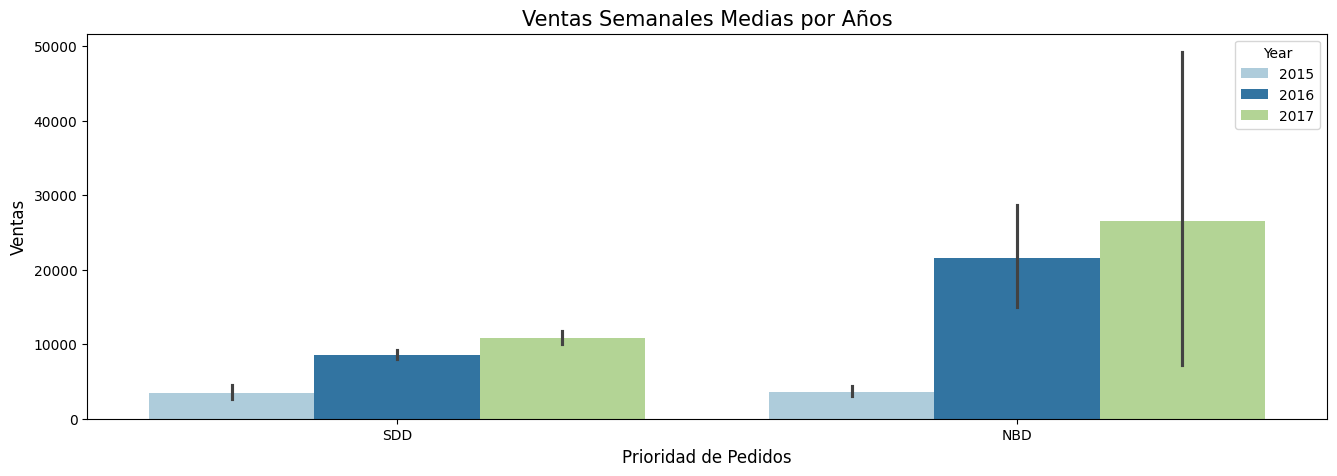

In [ ]:
# Ventas por Prioridad de Pedidos
# ==============================================================================
plt.figure(figsize = (16,5))
ax = sns.barplot(x="Prioridad_Pedido", y="Venta_Totales", hue="Year", data=df, palette= "Paired")
ax.set_title('Ventas Semanales Medias por Años',fontsize=15)
ax.set_xlabel('Prioridad de Pedidos',fontsize=12)
ax.set_ylabel('Ventas',fontsize=12)
plt.show()

In [ ]:
# Ventas Promedio por Prioridad de Pedidos
# ==============================================================================
df_gr_pedido = df.groupby('Prioridad_Pedido', as_index = False)\
    .agg({'Venta_Totales':'mean'})\
    .sort_values('Venta_Totales', ascending = False)

df_gr_pedido

,Prioridad_Pedido,Venta_Totales
1,SDD,6864.639186
0,NBD,4851.307074


**Las 5 mejores Familias de Productos en Ventas**

In [ ]:
# Ranking de los 5 mejores Tipos de Productos
# ==============================================================================
df_gr = df.groupby('Familia', as_index = False)\
    .agg({'Venta_Totales':'sum'})\
    .sort_values('Venta_Totales', ascending = False)

df_gr.head(5)

,Familia,Venta_Totales
35,Guitarra,34555224.27
11,Bateria,20949146.67
5,Amplificador,17071453.57
51,Piano,10376255.25
27,Controlador,9925855.54


<a id='part5'></a>
## <font color=#ba4a00><strong>Análisis de Ventas por Operaciones:

### **Ingresos por Gestión de Operaciones Logísticas - BLUEX**

In [ ]:
# Ventas Promedio por GL para cada Año
# ==============================================================================
df_gr_gl = df.groupby('Year', as_index = False)\
    .agg({'Total_Ingresos_Gestion_Logistica':'mean'})\
    .sort_values('Total_Ingresos_Gestion_Logistica', ascending = False)

df_gr_gl

,Year,Total_Ingresos_Gestion_Logistica
1,2016,1.007590e+06
2,2017,8.791200e+05
0,2015,4.402082e+05


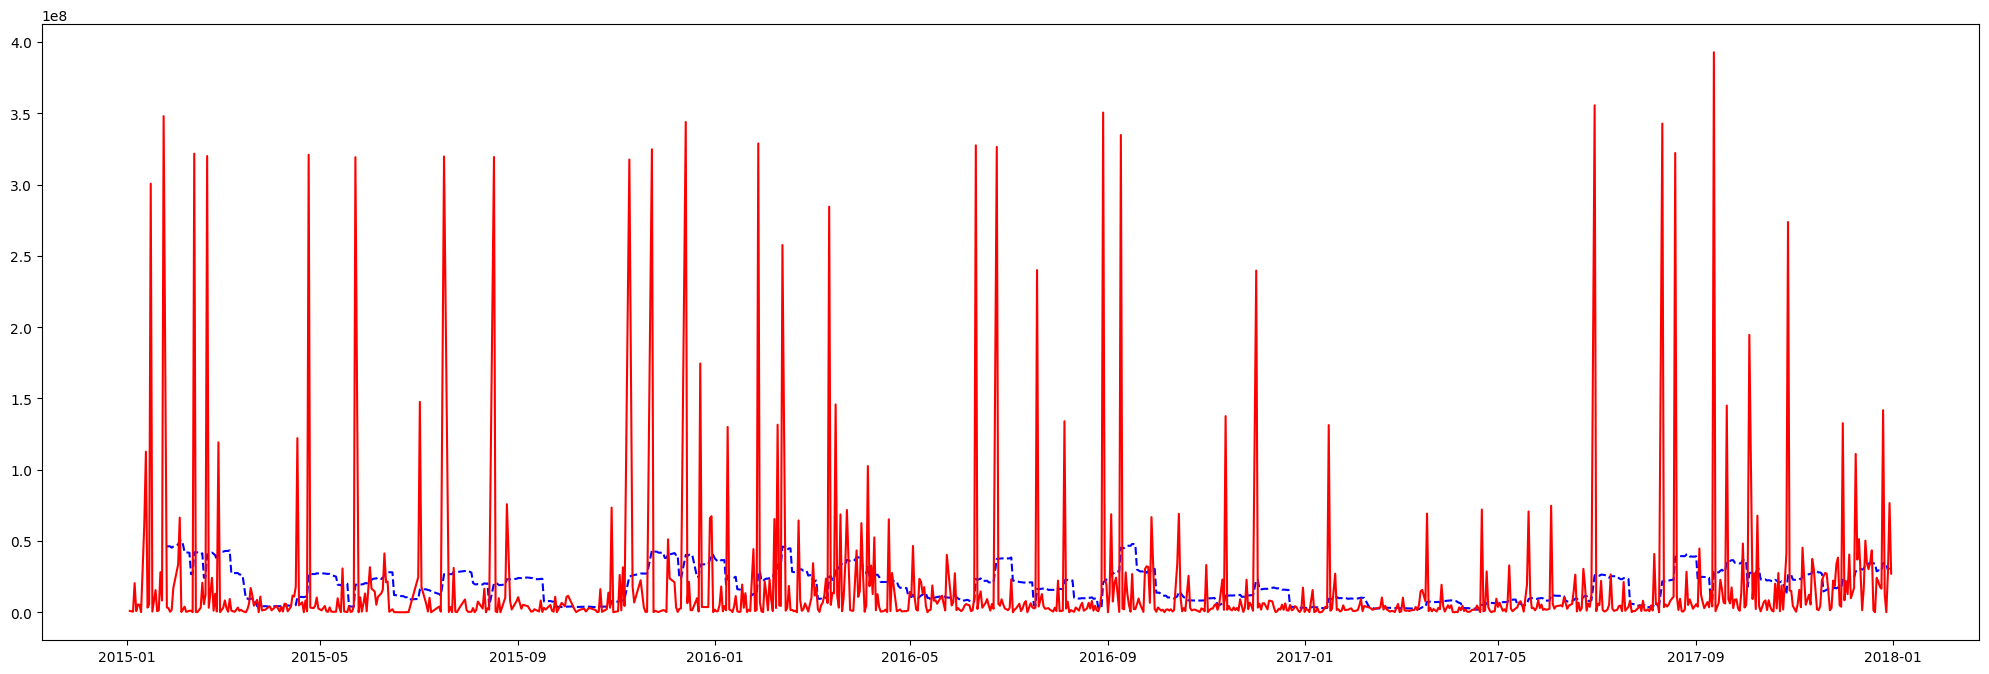

In [ ]:
# Análisis de los Ingresos por la Gestión Logística de BLUEX
# ==============================================================================
fig = plt.figure(figsize=(25,8))
df_venta_prom_sem2 = df.groupby('F_Orden', as_index=False)\
    .agg({'Total_Ingresos_Gestion_Logistica': 'sum'})
df_venta_prom_ordenada = df_venta_prom_sem2.sort_values('Total_Ingresos_Gestion_Logistica', ascending = False)


df_venta_prom_sem2['Media_mensual'] = df_venta_prom_sem2['Total_Ingresos_Gestion_Logistica'].rolling(20).mean()

line1 = plt.plot(df_venta_prom_sem2.F_Orden, df_venta_prom_sem2.Media_mensual, '--', color='b')


plt.plot(df_venta_prom_sem2.F_Orden, df_venta_prom_sem2.Total_Ingresos_Gestion_Logistica, color = 'r')
plt.show()

### **Tendencia del Precio de Venta**

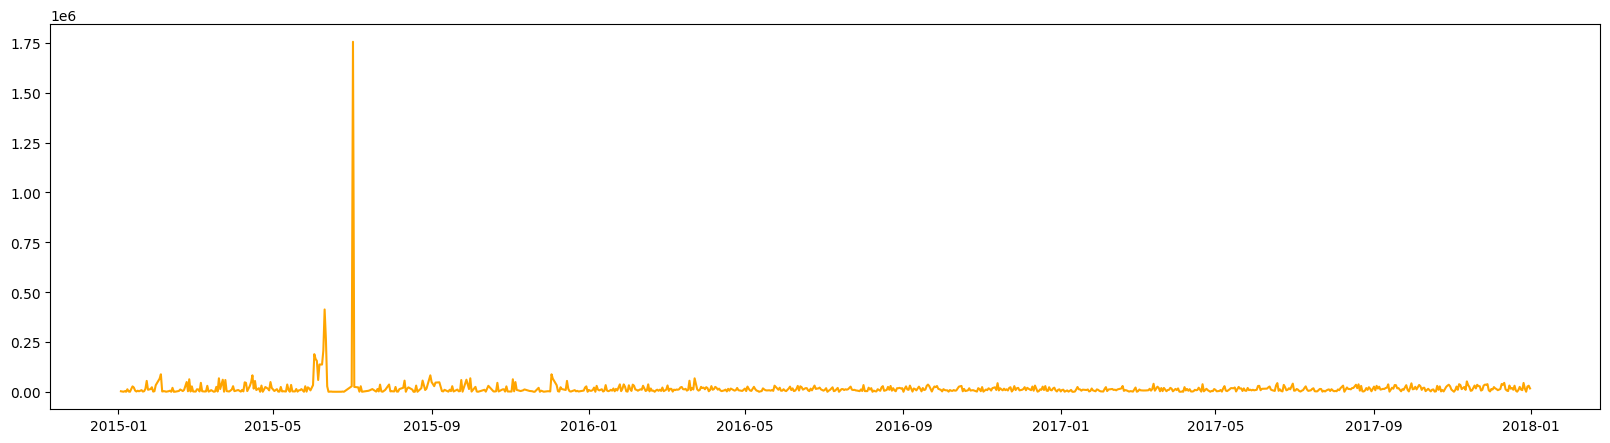

In [ ]:
# Tendencia del Precio de Venta
# ==============================================================================
df_ventas_prom_semanal2 = df.groupby('F_Orden', as_index=False)\
    .agg({'P_Venta': 'sum'})
df_prom_ventas_orden = df_ventas_prom_semanal2.sort_values('P_Venta', ascending = False)

plt.figure(figsize=(20,5))
plt.plot(df_ventas_prom_semanal2.F_Orden, df_ventas_prom_semanal2.P_Venta, color = 'orange')
plt.show()

### **Análisis del Rango de Edad**

In [ ]:
# Ventas por Rangos de Edades
# ==============================================================================
df_gr_rango = df.groupby('Rango_Edad')['Venta_Totales'].sum()
df_gr_rango

,Venta_Totales
Rango_Edad,
0-17,4611694.15
18-24,24524793.05
25-34,73603568.97
35-44,40726920.79
45-54,29055753.93


In [ ]:
# Numero de Transacciones por Rango
# ==============================================================================
df_conteo = df['Rango_Edad'].value_counts()
df_conteo

,count
Rango_Edad,
25-34,14463
35-44,5309
18-24,3044
45-54,2969
0-17,375


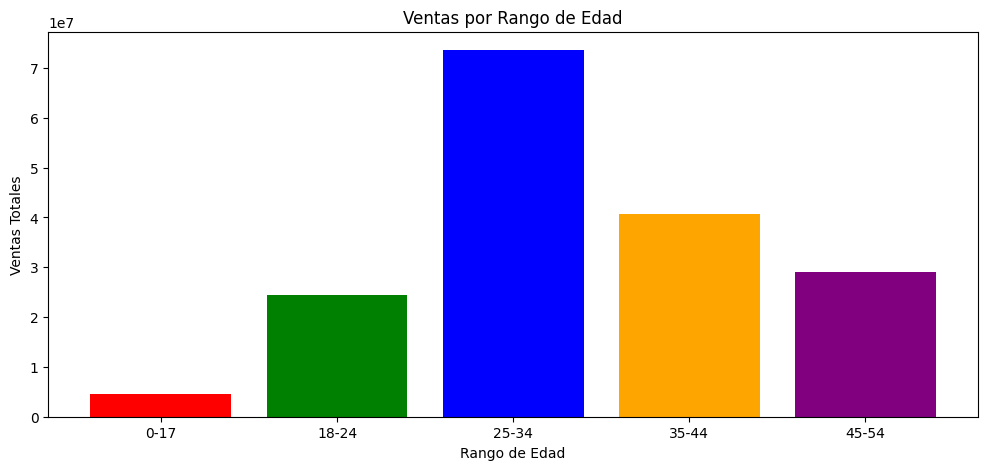

In [ ]:
# Ventas por Rango de Edad
# ==============================================================================

plt.figure(figsize = (12,5))

# Definbición de los colores por cada barra
colores = ['red', 'green', 'blue', 'orange', 'purple']
# Diagrama de barras para visualizar la suma de las ventas.
plt.bar(df_gr_rango.index, df_gr_rango.values, color = colores)

plt.xlabel("Rango de Edad")
plt.ylabel("Ventas Totales")
plt.title("Ventas por Rango de Edad")
plt.show()

<a id='part6'></a>
## <font color=#ba4a00><strong>Correlación de Características:

In [ ]:
# Análisis de correlación de características para Lima Oeste.
# ==============================================================================
df_lo = df.where( df['Zona'] == 'Lima Oeste')
df_lo = df_lo.groupby(by=['F_Orden'], as_index=False)[['Cant_Enviada', 'Peso', 'P_Venta', 'Inventario',
                                                  'Venta_Totales', 'Total_Ingresos_Gestion_Logistica']].mean()
df_lo = df_lo.set_index('F_Orden')
df_lo.head()

,Cant_Enviada,Peso,P_Venta,Inventario,Venta_Totales,Total_Ingresos_Gestion_Logistica
F_Orden,,,,,,
2015-01-03,2.0,5.600,12.168487,2.0,24.34,1724.359103
2015-01-05,140.0,0.150,39.950000,56.0,5593.00,198855.686538
2015-01-06,140.0,0.150,39.950000,56.0,5593.00,198855.686538
2015-01-07,71.5,2.025,29.478813,33.0,2825.01,73015.172686
2015-01-12,15.0,0.040,42.500000,16.0,637.50,24659.196154


##**Matriz de Correlación**

In [ ]:
# Matriz de Correlación
# ==============================================================================
corr = df_lo.corr()
corr

,Cant_Enviada,Peso,P_Venta,Inventario,Venta_Totales,Total_Ingresos_Gestion_Logistica
Cant_Enviada,1.000000,-0.066276,-0.002043,0.203237,0.595670,0.125879
Peso,-0.066276,1.000000,0.557054,-0.040309,0.100479,0.014936
P_Venta,-0.002043,0.557054,1.000000,-0.039864,0.381296,0.103863
Inventario,0.203237,-0.040309,-0.039864,1.000000,0.084437,0.048561
Venta_Totales,0.595670,0.100479,0.381296,0.084437,1.000000,0.208561
Total_Ingresos_Gestion_Logistica,0.125879,0.014936,0.103863,0.048561,0.208561,1.000000


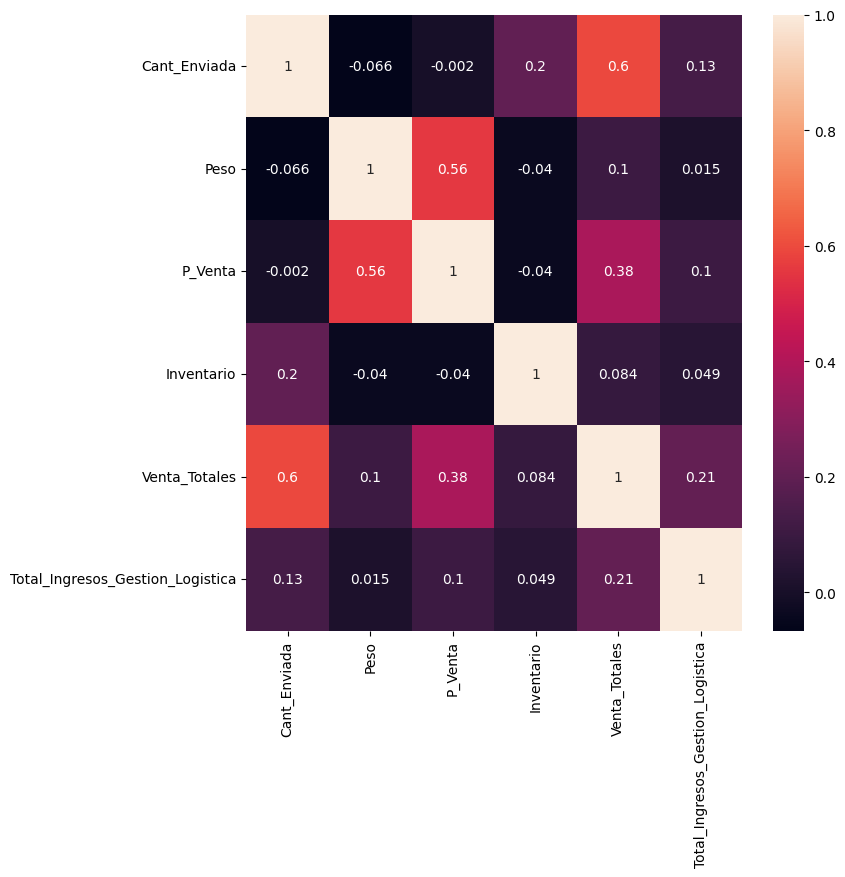

In [ ]:
# Matriz
# ==============================================================================
plt.figure(figsize=(7,7))
sns.heatmap(corr, annot=True)
plt.show()

<a id='part7'></a>
## <font color=#ba4a00><strong>Forecasting:

**Fbprophet sin regresores**

#### **Pronóstico de ventas general fuera de muestra con el modelo Fbprophet**

In [ ]:
# Preparación de Datos para Fbprophet
# ==============================================================================

df1 = df.groupby(by=['F_Orden'], as_index=False)['Venta_Totales'].sum()

df1 = df1.rename(columns = {'F_Orden':'ds', 'Venta_Totales':'y'})

df1.tail()

,ds,y
921,2017-12-27,337824.21
922,2017-12-28,1948.86
923,2017-12-29,786856.77
924,2017-12-30,2157956.64
925,2017-12-31,771350.31


In [ ]:
# Definir el Modelo
# ==============================================================================
model = Prophet()

# Ajuste del Modelo
# ==============================================================================
model.fit(df1)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplzdev36o/x1fytiq0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplzdev36o/63dgyla_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9484', 'data', 'file=/tmp/tmplzdev36o/x1fytiq0.json', 'init=/tmp/tmplzdev36o/63dgyla_.json', 'output', 'file=/tmp/tmplzdev36o/prophet_modelnu5faz4f/prophet_model-20240904012713.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:27:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:27:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# Ultima Fecha de Transacción
# ==============================================================================
df['F_Orden'].max()

Timestamp('2017-12-31 00:00:00')

In [ ]:
# Rango de Semanas para el Pronóstico
# ==============================================================================
fechas_futuras = pd.date_range("20180101","20180630", freq='W')

In [ ]:
# Convirtiendo las fechas en un str
# ==============================================================================
fechas_futuras = [pd.to_datetime(i) for i in fechas_futuras]

futuro = pd.DataFrame([dt.datetime.strftime(i, '%Y-%m-%d') for i in fechas_futuras],  columns=['ds'])

          ds           yhat     yhat_lower     yhat_upper
0 2018-01-07  564839.424563  218050.842059  970425.031145
1 2018-01-14  597016.925040  248882.254581  931547.528008
2 2018-01-21  610384.481502  247687.635576  978873.415331
3 2018-01-28  598603.349075  213649.153373  969422.650095
4 2018-02-04  581558.432366  215495.152843  956801.003919


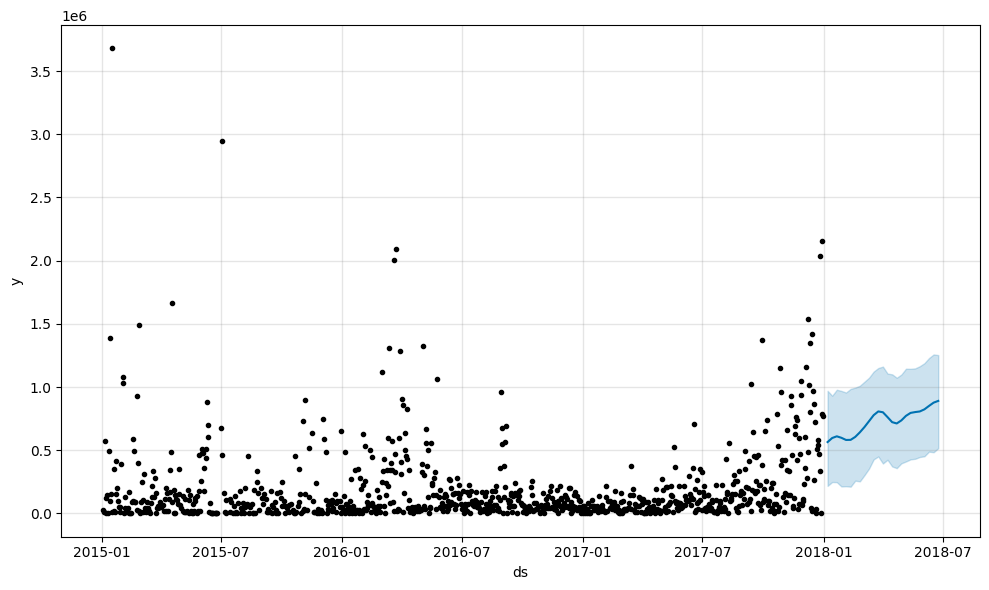

In [ ]:
# Proyección de acuerdo a la Fechas Futuras
# ==============================================================================
forecast = model.predict(futuro)

print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

# Plot Forecast
# ==============================================================================
model.plot(forecast)
plt.show()

#### **En muestra de Pronóstico general de Ventas con el modelo Fbprophet**

In [ ]:
# Muestra de Fechas para simulación del Proyectado
# ==============================================================================
fechas = pd.date_range("20170101","20171231", freq='W')
fechas = [pd.to_datetime(i) for i in fechas]
fechas_para_forecast = pd.DataFrame([dt.datetime.strftime(i, '%Y-%m-%d') for i in fechas],  columns=['ds'])

          ds           yhat     yhat_lower     yhat_upper
0 2018-01-07  564839.424563  218050.842059  970425.031145
1 2018-01-14  597016.925040  248882.254581  931547.528008
2 2018-01-21  610384.481502  247687.635576  978873.415331
3 2018-01-28  598603.349075  213649.153373  969422.650095
4 2018-02-04  581558.432366  215495.152843  956801.003919


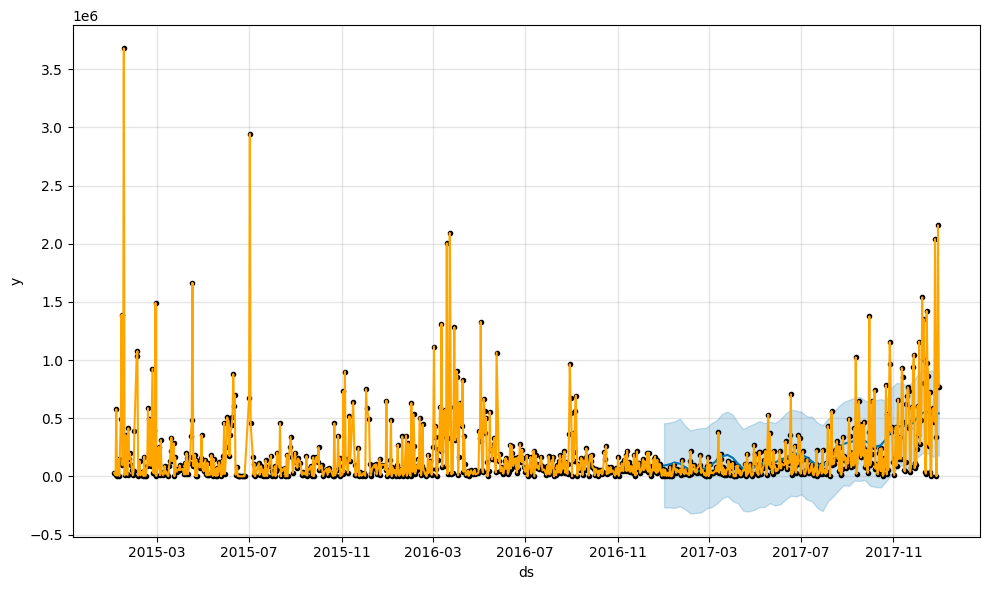

In [ ]:
# Proyectado para el rango de fechas
# ==============================================================================
forecast_fechas = model.predict(fechas_para_forecast)

# Resumen del Forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

# Plot Forecast
model.plot(forecast_fechas)

plt.plot(df1.ds, df1.y, color = 'orange')

plt.show()

**Fbprophet con Regresores**

#### **En la zona de Lima Oeste. Previsión de ventas con el modelo Fbprophet**

Tomamos la Cant_Enviada', 'Peso', 'P_Venta', 'Inventario', 'Venta_Totales' y el 'Total_Ingresos_Gestion_Logistica' como regresores para nuestro modelo.

In [ ]:
# Formamos el Grupo de datos
# ==============================================================================
df_grupo_lo = df.query('Zona == "Lima Oeste"')\
    .groupby(['F_Orden', 'Inventario', 'P_Venta', 'Total_Ingresos_Gestion_Logistica'], as_index = False)\
    .agg({'Venta_Totales':'sum'})
df_grupo_lo.head()

,F_Orden,Inventario,P_Venta,Total_Ingresos_Gestion_Logistica,Venta_Totales
0,2015-01-03,2,12.168487,1724.359103,24.34
1,2015-01-05,56,39.950000,198855.686538,5593.00
2,2015-01-06,56,39.950000,198855.686538,5593.00
3,2015-01-07,10,19.007625,3104.658834,57.02
4,2015-01-07,56,39.950000,142925.686538,5593.00


In [ ]:
# Preparación de datos para Fbprophet
# ==============================================================================

df_grupo_lo = df_grupo_lo.rename(columns = {'F_Orden':'ds','Venta_Totales':'y'})

datetime_series = pd.to_datetime(df_grupo_lo['ds'])

datetime_index = pd.DatetimeIndex(datetime_series.values)

zonalo_data = df_grupo_lo.set_index(datetime_index)
zonalo_data.head()

,ds,Inventario,P_Venta,Total_Ingresos_Gestion_Logistica,y
2015-01-03,2015-01-03,2,12.168487,1724.359103,24.34
2015-01-05,2015-01-05,56,39.950000,198855.686538,5593.00
2015-01-06,2015-01-06,56,39.950000,198855.686538,5593.00
2015-01-07,2015-01-07,10,19.007625,3104.658834,57.02
2015-01-07,2015-01-07,56,39.950000,142925.686538,5593.00


In [ ]:
# Mostramos el número de filas y columnas
# ==============================================================================
print("La cantidad de columnas es: ",zonalo_data.shape[1])
print("La cantidad de filas es: ",zonalo_data.shape[0])

La cantidad de columnas es:  5
La cantidad de filas es:  10077


In [ ]:
# Entrenamos los datos
# ==============================================================================
train_data_pr1 = zonalo_data.iloc[:len(zonalo_data)-40]
test_data_pr1 = zonalo_data.iloc[len(zonalo_data)-40:]

test_data_pr2 = test_data_pr1[['ds', 'Inventario', 'P_Venta', 'Total_Ingresos_Gestion_Logistica']]

In [ ]:
# Definimos el Modelo
# ==============================================================================
m1 = Prophet(changepoint_prior_scale=0.05, interval_width=0.95,growth = 'linear',seasonality_mode = 'multiplicative', \
               yearly_seasonality=20, weekly_seasonality=True, changepoint_range=0.9)
m1.add_seasonality('weekly', period=7, fourier_order=15)

m1.add_regressor('Inventario')
m1.add_regressor('P_Venta')
m1.add_regressor('Total_Ingresos_Gestion_Logistica')
m1.fit(train_data_pr1)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplzdev36o/iobi9v7c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplzdev36o/7hyzxvjs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6371', 'data', 'file=/tmp/tmplzdev36o/iobi9v7c.json', 'init=/tmp/tmplzdev36o/7hyzxvjs.json', 'output', 'file=/tmp/tmplzdev36o/prophet_model3lgfm07n/prophet_model-20240904022601.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:26:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:26:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper
35 2017-12-31  161223.040185  122159.275563  198814.424226
36 2017-12-31    4551.048390  -33720.784349   43272.244340
37 2017-12-31   -9420.793939  -49119.465136   28096.077177
38 2017-12-31   -1123.619570  -41822.344344   37810.467035
39 2017-12-31    2339.178980  -39126.799060   41574.400125


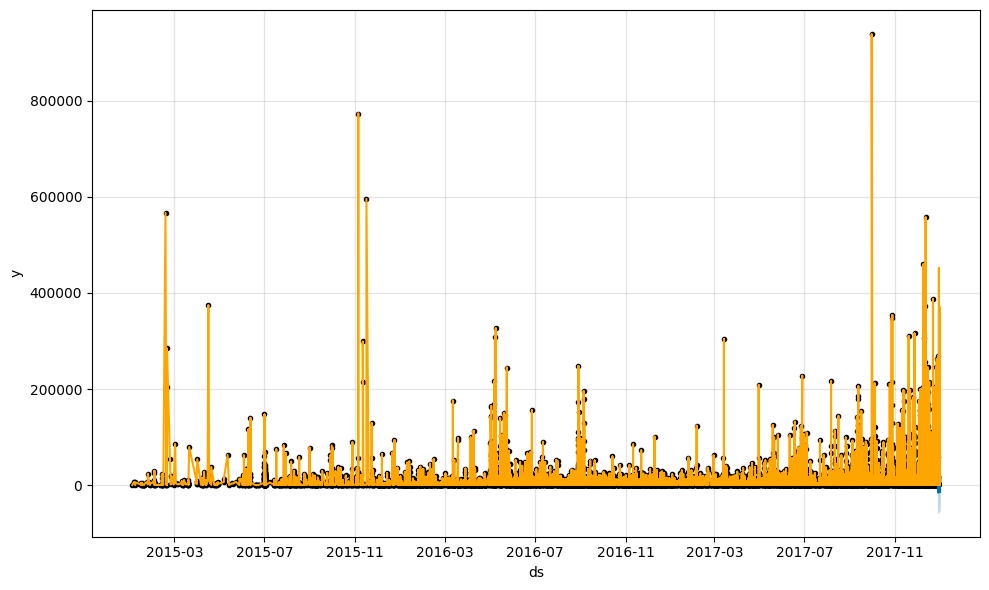

In [ ]:
# Grafico
# ==============================================================================

prophet_pred2 = m1.predict(test_data_pr2)


print(prophet_pred2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

# Plot Forecast
m1.plot(prophet_pred2)


plt.plot(zonalo_data.ds, zonalo_data.y, color = 'orange')

plt.show()

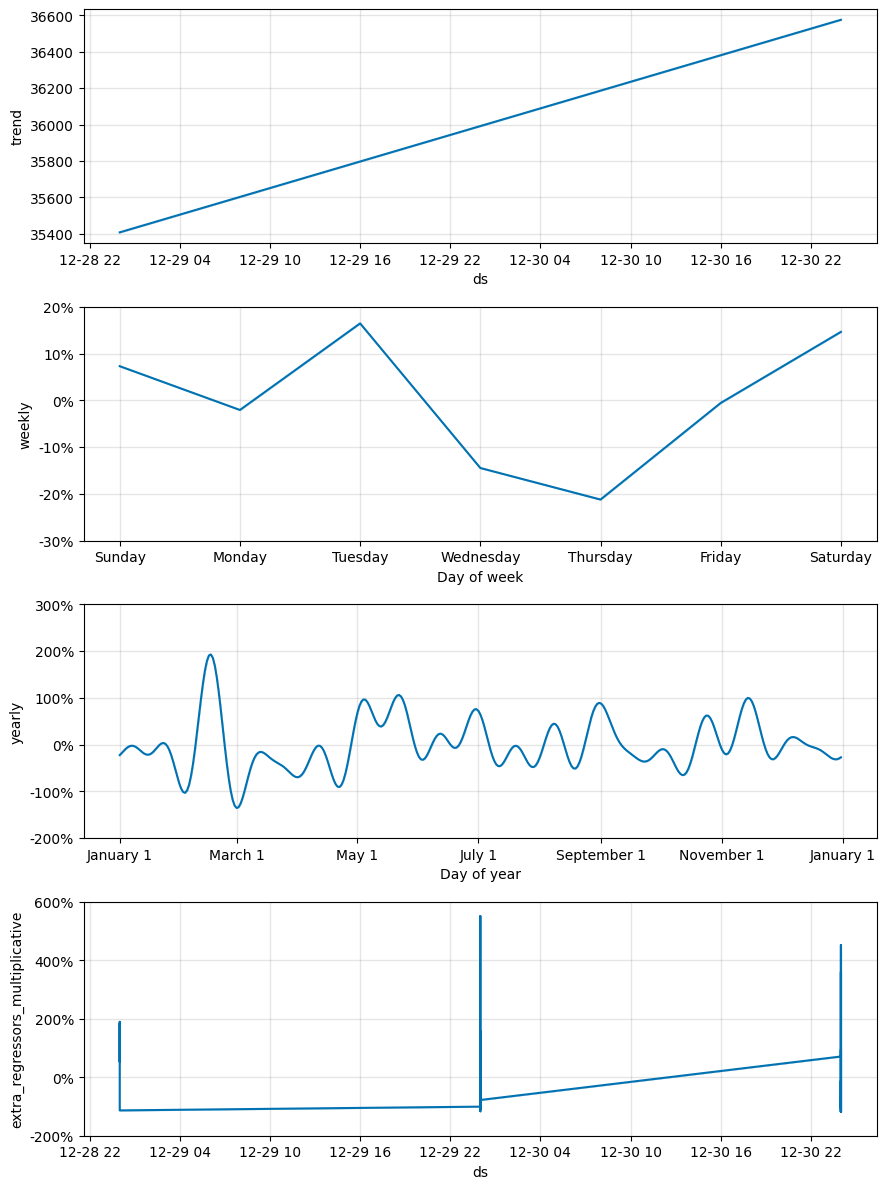

In [ ]:
# Graficos por periodos
# ==============================================================================
m1.plot_components(prophet_pred2)
plt.show()

In [ ]:
# Regresores
# ==============================================================================
zonalo_data_2 = zonalo_data[['ds', 'Inventario', 'P_Venta', 'Total_Ingresos_Gestion_Logistica']]

              ds           yhat     yhat_lower     yhat_upper
10072 2017-12-31  -13904.442115  -50603.180648   24146.072567
10073 2017-12-31  161223.040185  122708.488524  198313.404795
10074 2017-12-31    4551.048390  -37730.079411   40242.448840
10075 2017-12-31   -1123.619570  -37841.640699   36215.536590
10076 2017-12-31    2339.178980  -34119.381523   40059.134122


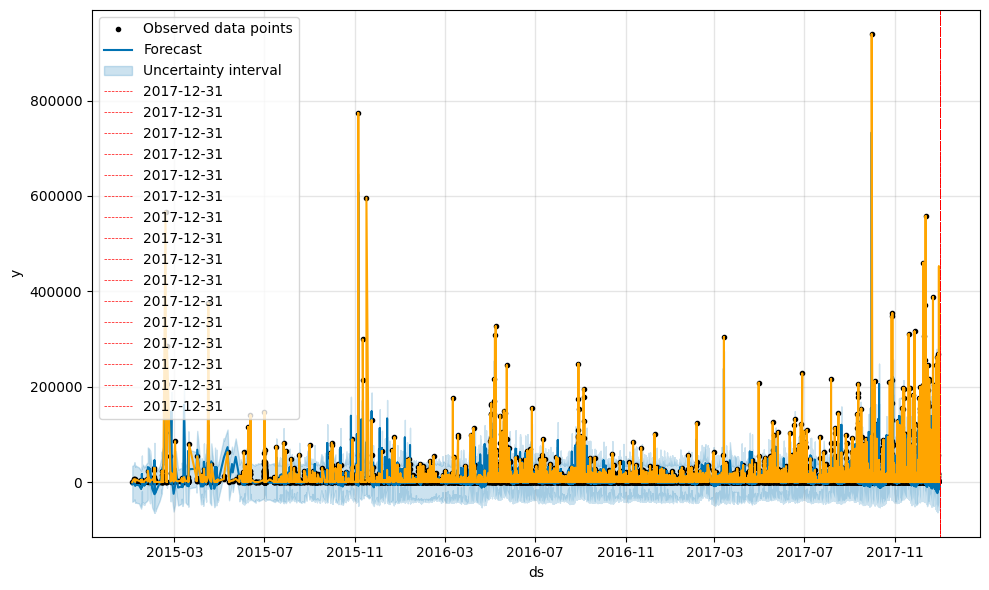

In [ ]:
# Grafico con Ajuste de Fecha
# ==============================================================================
prophet_pred2 = m1.predict(zonalo_data_2)


print(prophet_pred2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

# Plot Forecast
m1.plot(prophet_pred2)


plt.plot(zonalo_data.ds, zonalo_data.y, color = 'orange')

for x in zonalo_data[zonalo_data['ds']=='2017-12-31']['ds']:
    plt.axvline(x=x, color='red', linewidth=0.5, ls='--', label='2017-12-31')


plt.legend()

plt.show()

In [ ]:
# Tercera Proyección
# ==============================================================================
prophet_pred3 = prophet_pred2[['ds','yhat']]

df_ds = pd.merge(zonalo_data, prophet_pred3, on=['ds'], how='left')

df_ds['diff'] = (df_ds['y']-df_ds['yhat'])/df_ds['y']

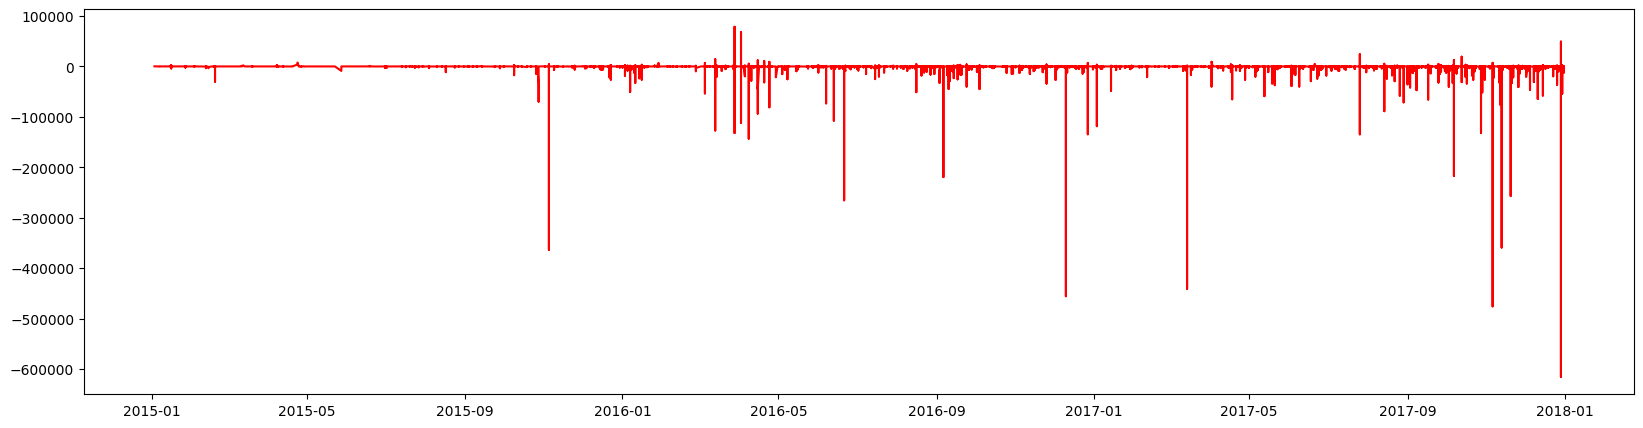

In [ ]:
# Grafico de la Proyección
# ==============================================================================

x1 = df_ds['ds']
y1 = df_ds['diff']
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(x1.values, y1.values, c='r')
plt.show()

In [ ]:
# Estadísticas de las Diferencias Obtenidas
# ==============================================================================
df_ds['diff'].describe()

,diff
count,235859.000000
mean,-180.464712
std,3765.884197
min,-615141.993264
25%,-5.656784
50%,-0.022278
75%,0.960904
max,78603.879189


In [ ]:
df['Zona'].unique()

array(['Lima Centro', 'Lima Oeste', 'Lima Norte', 'Metropolitano',
       'Lima Este', 'Lima Sur'], dtype=object)

In [ ]:
df[df['Zona']=='Lima Oeste']['Distrito'].unique()

array(['Miraflores', 'Surco', 'San Isidro', 'Surquillo', 'San Borja'],
      dtype=object)